Here, we only have two groups:
- Group2: the censored parts, for which we only know the number. $0 < y^* < l$.
- Group3: the observed parts, $y^* > l$.

For the model 

\begin{equation}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}.
\end{equation}

What happened if $\alpha < c$?

then $\alpha*y < c*y <l $. It means that all damaged pieces are censored. So we don't have damaged pieces. The remaining pieces in group 3 are all undamaged. Then we can only have the range of $\alpha$ but no specific estimate.

In bivarite dataset, we don't have this problem because we have $c*x$ and $\alpha*y$.

In [346]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [347]:
@jax.jit

def indicator(x):
    return(jnp.select([x>0,x<=0],[1,0]))

def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))


def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_ind(y,alpha,l,c):
    return(y*indicator(c*y-l) + alpha*y*indicator(l-c*y))


def dmgmodel_py(y,alpha,l,c,s):
    #return(y*jax.scipy.stats.norm.cdf(c*y-l) + alpha*y*jax.scipy.stats.norm.cdf(l-c*y))
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

    #return(y*g_smooth(c*y-l) + alpha*y*g_smooth(l-c*y))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    ystar = jnp.array(ystar)
    bisec = jaxopt.Bisection(
        optimality_fun=dmgmodel_root_py,
        lower = 0,
        upper = 10000,
        check_bracket = False)
    return(bisec.run(alpha = alpha,l = l, c= c ,s = s,ystar = ystar).params)

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
   # y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [348]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.25
c = 0.65
s = 10

N_marginal = 139





In [349]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[2], shape=(N, )) + mu
y = y[y>0]

y_obs = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(y)

y_group2 = jnp.shape(y_obs[y_obs < l ])[0]
y_group3 = y_obs[y_obs > l ]



In [350]:
y[:5]
y_obs[:5]

Array([73.15903 , 68.201485, 30.201897, 34.644985, 38.13375 ], dtype=float32)

Array([73.15903 , 68.201485,  7.550474,  8.661246,  9.533438], dtype=float32)

In [351]:
s= s
l = l 

@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    lik2 = y_group2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(dmginverse_py(1e-6,alpha,l,c,s), loc=mu, scale=sigma)
        )
    lik3 = dmglik_vmap(y_group = y_group3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

    return(-lik2-lik3)

#theta0 = jnp.array([alpha])
negdmglik_jax(theta0)

Array(723.1334, dtype=float32)

In [352]:

theta0 = jnp.array([mu,sigma,alpha,c])

solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([4.8929794e+01, 1.6205273e+01, 1.4266989e-03, 6.4399159e-01],      dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(718.40326, dtype=float32), success=True, status=0, iter_num=171, hess_inv=None))

Array([48.  , 19.  ,  0.25,  0.65], dtype=float32)

Array([[2.4464897e+01, 7.3394691e+01],
       [8.1026363e+00, 2.4307909e+01],
       [7.1334944e-04, 2.1400484e-03],
       [3.2199579e-01, 9.6598738e-01]], dtype=float32)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


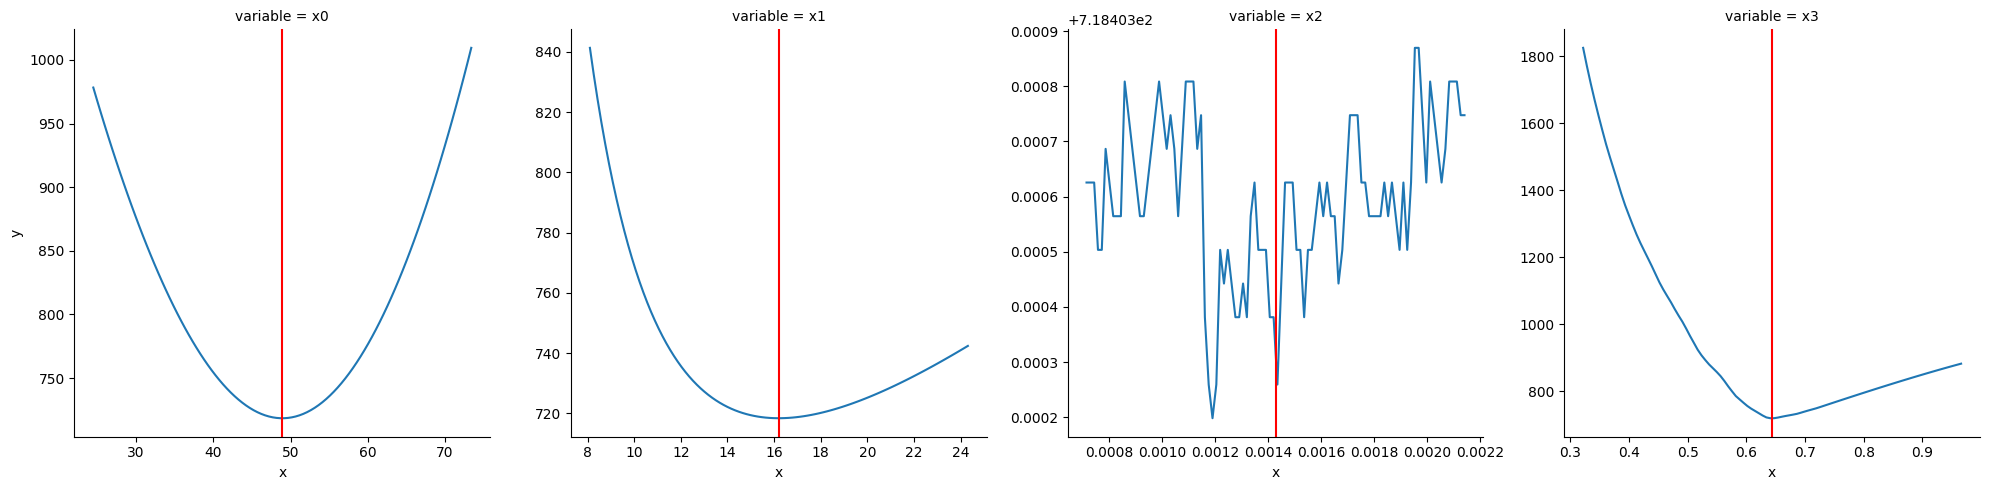

In [353]:
#alpha_seq = jnp.arange(res.params-0.1,res.params+0.1,0.01)
# alpha_seq = jnp.arange(alpha-0.1, alpha+0.1,0.01)
# lik_seq = jax.vmap(negdmglik_jax)(alpha_seq )
# plt.plot(alpha_seq,lik_seq)



xsol = res.params
xrange = .5
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    opt_vlines=True
)

In [354]:
# negdmglik_jax(.1)
# negdmglik_jax(.3)


# dmglik_vmap(y_group = y_group3,alpha = .1,l = l, c = c,s = s, mu = mu, sigma = sigma)
# dmglik_vmap(y_group = y_group3,alpha = .3,l = l, c = c,s = s, mu = mu, sigma = sigma)

In [355]:
# xsol = res.params
# xrange = .5
# theta_upper = xsol  + xrange *jnp.abs(xsol)
# theta_lower = xsol - xrange * jnp.abs(xsol)
# theta_rng_trans = jnp.array([theta_lower, theta_upper])

# #res.params
# theta_rng = jnp.transpose(theta_rng_trans)
# theta_rng
# # plot at the true value theta0
# pjp.proj_plot(
#     fun=negdmglik_jax,
#     x_opt=xsol,
#     x_lims=theta_rng, 
#     n_pts=100, 
#     x_names= ['mu','sigma','alpha'],
#     opt_vlines=True
# )